# WEEK 1

**Week 1**

*Installing Google Earth Engine API*

In [11]:
# Install required libraries
!pip install earthengine-api geemap --quiet


*Importing libraries*

In [12]:
# Import packages
import ee
import geemap
import pandas as pd
import os


Connecting it to Google Drive

In [3]:
df=pd.read_csv('glofdatabase_v4-1.csv')
pd.set_option('display.max_columns',None)
df.shape

(684, 77)

In [4]:
df.head(5)

,ID,Major_RGI_Region,Mountain_range_Region,Country,Glacier,RGI_Glacier_Id,RGI_Glacier_Area,Lake,Lake_type,Longitude,Latitude,River,Date,Date_Min,Date_Max,Mechanism,Mean_Lake_Volume_VL,Min_VL,Max_VL,VL_calculation,Mean_Flood_Volume_V0,Min_V0,Max_V0,V0_calculation,Peak_discharge_Qp,Min_Qp,Max_Qp,Qp_calculation,Impact_and_destruction,reported_impacts,economic_losses,D_buildings,D_bridges,D_roads_paths,D_railroads,D_utilities,D_flood_protection,D_environmental,resettlement,reported_fatalities,Further_comments,First_reference_found,Reference,Reference_comments,Lake_area_before,Perimeter_before,Image_date_before,Satellite_before,Scenename_before,Certainty_level_before,Lake_area_after,Perimeter_after,Image_date_after,Satellite_after,Scenename_after,Certainty_level_after,Lake_area_comments,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76
0,running number (regionally),RGI region in which the GLOF occurred,Major mountain unit/range in which the GLOF wa...,Source location of the GLOF,Name of the glacier that feeds the burst glaci...,Glacier Id derived from RGI polygon,Glacier area derived from RGI polygon,Name of the outburst source lake,Material of the impounding dam,X coordinate,Y coordinate,Major river basin that captured GLOF discharge,Reported date of GLOF,Earliest possible date,Latest possible date,Mechanism that causes the dam to fail,Volume before outburst,Minimum reported lake volume,Maximum reported lake volume,Method to obtain lake volumes before outburst,Total volume released during outburst,Minimum reported flood volume,Maximum reported flood volume,Method to obtain V0,Maximum discharge during outburst,Minimum reported peak discharge,Maximum reported peak discharge,Method to obtain Qp,Quantitative and qualitative descriptions of s...,Reported impacts (categorized),Occurrence of economic losses,Damage to buildings,Damage to bridges,Damage to roads or paths,Damage to railroads,Damage to utilities,Damage to flood protection measures,Damage to the environment,Need for resettlement after the flood,Fatalities in consequence of the flood,Any other useful information,Year of first reference that cited the GLOF,References viewed to gather information,Comments on the reference,Lake area before outburst,Lake perimeter before outburst,Date of satellite image used for mapping,Satellite from which the image was derived,Scenename,"1 – unsure (clouds, shadows,…)",lake area after outburst,Lake perimeter before outburst,Date of satellite image used for mapping,Satellite from which the image was derived,Scenename,"1 – unsure (clouds, shadows,...)",Mapping notes and comments,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,e.g. Karakoram,e.g. Pakistan,e.g. Baltoro Glacier,NaN,km2,e.g. Baltoro Lake 1,"e.g ice, moraine, water pocket, bedrock, combined",XX.XX°,XX.XX°,e.g. Indus,YYYY-MM-DD,YYYY-MM-DD,YYYY-MM-DD,"(e.g. overtopping, breach, tunnelling, englac...",106 m³,106 m³,106 m³,e.g. bathymetry,106 m³,106 m³,106 m³,gaged / estmated / unknown,m³ s-1,m³ s-1,m³ s-1,gaged / estmated / unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(e.g. water or electricity supply),(e.g. levees),(e.g. fish population),NaN,NaN,NaN,NaN,NaN,NaN,m²,m,YYYY-MM_DD,NaN,NaN,2 – sure,m²,m,YYYY-MM_DD,NaN,NaN,2 – sure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Low Latitudes,Low-latitude Andes,Peru,RGI60-16.02480,RGI60-16.02480,4.52,Rajururi,moraine,-77.68,-9.06,NaN,1725-01-06,NaN,NaN,breach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,earthquake triggered,1942,"Broggi, J. A. (1942). Informe preliminar sobre...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,Southern Andes,C A


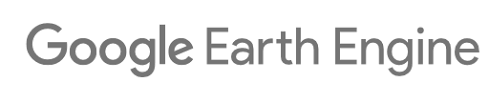
[Google Earth Engine Code](https://code.earthengine.google.com/)


**GEE Authentication & Initialization**

In [46]:
ee.Authenticate()
ee.Initialize(project='fleet-hawk-463015-h5')

Enter verification code:  4/1AVMBsJhUfS8HPtrlZThH_gV8tPipqGI_UcwJbCK2Zh67dC0VxojkI5gyzgk



Successfully saved authorization token.


## Lake Detection & Visualization

In [6]:
# Create interactive map
Map = geemap.Map(basemap='SATELLITE',center=[27.71, 85.32],zoom=7)
Map.add_draw_control()


# Load all countries from Earth Engine
world_borders = ee.FeatureCollection("FAO/GAUL/2015/level1")

styled_world = world_borders.style(**{
    'color': 'red',
    'width': 2,
    'fillColor': '00000000'  # Transparent fill
})
Map.addLayer(styled_world, {}, 'FAO Country Borders')

Map


Map(center=[27.71, 85.32], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

Returns Geometry(ROI) that user drew on the map.

Returns Geometry(ROI) that user drew on the map.

In [7]:
roi = Map.user_roi
if roi is None:
  print("No ROI selected, Please select roi using the interactive map")
else:
  print("ROI loaded")
  print(type(roi))

#Map.user_roi is a variable that holds an object of class ee.Geometry. it is assigned the geometry object when the user draws on the map


No ROI selected, Please select roi using the interactive map


In [12]:
def count_lakes(lakes_fc):
    count = lakes_fc.size()
    n = count.getInfo()
    print(f" Number of lakes detected: {n}")
    return n

Lake detection(forming ee.FeatureCollection with lake polygons by taking lake coordinate and time frame, 

In [33]:
import ee


def detect_lake_from_point(point, start_date, end_date,
                        search_radius=800, ndwi_thresh=0.30):

    aoi = point.buffer(search_radius)

    # Load Landsat 8/9 SR
    collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(aoi))

    # Scale factors for SR
    def scale_sr(img):
        optical = img.select('SR_B[0-9]*').multiply(0.0000275).add(-0.2)
        thermal = img.select('ST_B.*').multiply(0.00341802).add(149.0)
        return img.addBands(optical, overwrite=True).addBands(thermal, overwrite=True)

    collection = collection.map(scale_sr)

    # Add NDWI band
    def add_ndwi(img):
        ndwi = img.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
        return img.addBands(ndwi)
    collection = collection.map(add_ndwi)

    # Check empty collection
    if collection.size().getInfo() == 0:
        raise Exception("No usable Landsat images found")

    # Median NDWI
    ndwi_median = collection.select('NDWI').median().clip(aoi)

    # Safeguard: check band names
    if len(ndwi_median.bandNames().getInfo()) == 0:
        raise Exception("NDWI band missing after processing")

    # Water mask
    water_mask = ndwi_median.gt(ndwi_thresh)

    # Vectorize
    lake_fc_all = water_mask.selfMask().reduceToVectors(
        geometry=aoi,
        scale=30,
        geometryType='polygon',
        reducer=ee.Reducer.countEvery(),
        maxPixels=1e13
    )

    def add_area(f): return f.set('area_km2', f.geometry().area(maxError=1).divide(1e6))
    lake_fc_all = lake_fc_all.map(add_area)

    largest = ee.Feature(lake_fc_all.sort('area_km2', False).first())

    return {
        'lake_fc': ee.FeatureCollection([largest]),
        'area_km2': largest.get('area_km2'),
        'ndwi_median': ndwi_median
    }




In [34]:
lat, lon = 36.879,73.704

point = ee.Geometry.Point([lon, lat])

# Call Landsat-only function
res = detect_lake_from_point(
    point,
    start_date="2016-09-01",
    end_date="2016-12-30"
)

# Print lake area
print("Lake area (km²):", res['area_km2'].getInfo())

Lake area (km²): 0.0021547874021803828


In [24]:
'''labels.reduceRegion(...) → Summarizes the values of labels within a specific geometry (here: point).

reducer=ee.Reducer.first() → Returns the first non-null pixel value in that geometry.

Since the geometry is a single point, "first" just means "that pixel value".

geometry=point → The exact point you passed to the function.

scale=10 → Pixel size in meters; matches Sentinel-2 resolution.

.get('labels') → Extracts the numeric label ID from the dictionary returned by reduceRegion.

If the point is on water: returns a positive integer (e.g., 3).

If the point is not on water: returns None (null).'''

'labels.reduceRegion(...) → Summarizes the values of labels within a specific geometry (here: point).\n\nreducer=ee.Reducer.first() → Returns the first non-null pixel value in that geometry.\n\nSince the geometry is a single point, "first" just means "that pixel value".\n\ngeometry=point → The exact point you passed to the function.\n\nscale=10 → Pixel size in meters; matches Sentinel-2 resolution.\n\n.get(\'labels\') → Extracts the numeric label ID from the dictionary returned by reduceRegion.\n\nIf the point is on water: returns a positive integer (e.g., 3).\n\nIf the point is not on water: returns None (null).'

In [31]:
lake_point = ee.Geometry.Point([73.704, 36.879])

ndwi_img, lake_poly = detect_lake_from_point(
    point=lake_point,
    start_date='2022-06-01',
    end_date='2022-09-30',
    search_radius=2000,  # try bigger radius
    ndwi_thresh=0.2      # try looser threshold
)

Map = visualize_ndwi_and_lakes(
    ndwi_image=ndwi_img,
    lakes_fc=lake_poly,
    polygon=lake_point.buffer(2000),
    year=2022
)
Map



AttributeError: 'str' object has no attribute 'style'

In [11]:
ndwi_2024, lakes_2024= detect_lakes_by_ndwi(2024,roi)


In [12]:
count_lakes(lakes_2024)

 Number of lakes detected: 5


5

In [21]:
import geemap

def visualize_ndwi_and_lakes(ndwi_image, lakes_fc, polygon, year=2024):
    """
    Visualizes NDWI image and detected lakes on an interactive map.
    """
    Map = geemap.Map(basemap='SATELLITE',center=[36.879, 73.704], zoom=10)
    Map.addLayer(ndwi_image, {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, f'NDWI {year}')
    Map.addLayer(lakes_fc.style(**{'color': 'cyan', 'fillColor': '0000ff80'}), {}, f'Lakes {year}')
    Map.addLayer(polygon, {'color': 'red'}, 'ROI')

    return Map

In [14]:
visualize_ndwi_and_lakes(ndwi_2024, lakes_2024, roi)

Map(center=[27.75, 86.85], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright'…

# WEEK 2

**WEEK 2**

In [20]:

# Add centroid coordinates to each feature
def add_centroid_coords(feature):

    # Get the centroid of the feature's geometry (lake polygon)
    #   - ee.ErrorMargin(1) specifies a 1-meter error tolerance in calculation.
    #   - The result is an ee.Geometry.Point object.
    centroid = feature.geometry().centroid(ee.ErrorMargin(1))

    # Add two new properties to the feature:
    #   'centroid_lat' → the latitude of the centroid (index 1 in [lon, lat])
    #   'centroid_lon' → the longitude of the centroid (index 0 in [lon, lat])
    #   centroid.coordinates() returns an ee.List: [longitude, latitude]
    return feature.set({
        'centroid_lat': centroid.coordinates().get(1),  # latitude
        'centroid_lon': centroid.coordinates().get(0)   # longitude
    })


In [21]:

# Add a unique lake ID to each feature
def add_lake_id(feature):
    """
    Creates a reproducible unique lake_id from centroid coordinates.
    This helps track the same lake across years or datasets.
    """

    # Get centroid latitude from feature properties, ensure it's an ee.Number,
    # and format it to a string with exactly 6 decimal places for consistency.
    lat = ee.Number(feature.get('centroid_lat')).format('%.6f')

    # Do the same for centroid longitude
    lon = ee.Number(feature.get('centroid_lon')).format('%.6f')

    # Build the lake_id string in the format: lake_<lat>_<lon>
    #   - ee.String('lake_') → start with the prefix
    #   - .cat(lat) → append latitude string
    #   - .cat('_') → add an underscore separator
    #   - .cat(lon) → append longitude string
    lake_id_str = ee.String('lake_').cat(lat).cat('_').cat(lon)

    # Add the new 'lake_id' property to the feature's property dictionary
    # and return the updated feature
    return feature.set('lake_id', lake_id_str)

In [22]:
# Add area for a given year
def add_lake_area(feature, year, scale=30):
    """Calculates lake area (km²) and stores it as a property."""

    # Create an image where each pixel value = pixel area in km²
    pixel_area_km2 = ee.Image.pixelArea().divide(1e6).rename('area')

    # Sum pixel areas inside the lake polygon
    area = pixel_area_km2.reduceRegion(
        reducer=ee.Reducer.sum(),        # sum all pixel values
        geometry=feature.geometry(),     # use lake's polygon
        scale=scale,                     # resolution in meters
        maxPixels=1e13                    # allow large calculations
    ).get('area')

    # Add computed area to feature properties
    return feature.set(f'area_km2_{year}', area)

In [23]:
#Enrich lakes with available properties
#1
def enrich_lakes(lakes_fc, year, scale=30):
    """Adds centroid, lake ID, and area to each feature."""
    lakes_fc = lakes_fc.map(add_centroid_coords)
    lakes_fc = lakes_fc.map(add_lake_id)
    lakes_fc = lakes_fc.map(lambda f: add_lake_area(f, year, scale))
    return lakes_fc

In [24]:
#Convert FeatureCollection to Pandas DataFrame
def lakes_to_df(lakes_fc):
    """Converts EE FeatureCollection to a Pandas DataFrame."""
    return geemap.ee_to_df(lakes_fc)

In [25]:
lakes_fc_2024 = enrich_lakes(lakes_2024, 2024, 30)
df_2024 = lakes_to_df(lakes_fc_2024)

In [26]:
df_2024.head()

,area,area_km2_2024,centroid_lat,centroid_lon,count,label,lake_id
0,378995.874569,0.378364,27.874191,86.586037,4297,1,lake_27.874191_86.586037
1,293695.492215,0.293561,27.780408,86.613991,3327,1,lake_27.780408_86.613991
2,235514.686348,0.235016,27.742659,86.844783,2667,1,lake_27.742659_86.844783
3,297215.534628,0.296743,27.687292,86.858751,3364,1,lake_27.687292_86.858751
4,525462.949261,0.524339,27.771688,86.869145,5952,1,lake_27.771688_86.869145


In [30]:
# 1. Function to add elevation to each feature
def add_lake_elevation(feature):
    dem = ee.Image("USGS/SRTMGL1_003")  # SRTM 30m DEM
    elevation = dem.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=feature.geometry().centroid(1),
        scale=30
    ).get('elevation')
    return feature.set('elevation_m', elevation)

# 2. Update enrich_lakes to include elevation
def enrich_lakes(lakes_fc, year, scale=30):
    lakes_fc = lakes_fc.map(add_centroid_coords)
    lakes_fc = lakes_fc.map(add_lake_id)
    lakes_fc = lakes_fc.map(lambda f: add_lake_area(f, year, scale))
    lakes_fc = lakes_fc.map(add_lake_elevation)
    return lakes_fc

lakes_fc_2024 = enrich_lakes(lakes_2024, 2024, 30)
df_2024 = lakes_to_df(lakes_fc_2024)

In [29]:
df_2024.head()

,area,area_km2_2024,centroid_lat,centroid_lon,count,elevation_m,label,lake_id
0,378995.874569,0.378364,27.874191,86.586037,4297,4368,1,lake_27.874191_86.586037
1,293695.492215,0.293561,27.780408,86.613991,3327,4831,1,lake_27.780408_86.613991
2,235514.686348,0.235016,27.742659,86.844783,2667,4368,1,lake_27.742659_86.844783
3,297215.534628,0.296743,27.687292,86.858751,3364,4764,1,lake_27.687292_86.858751
4,525462.949261,0.524339,27.771688,86.869145,5952,4940,1,lake_27.771688_86.869145


# WEEK 5

**Lake Expansion Rate **

In [1]:
import ee
import pandas as pd
ee.Initialize()

def get_landsat_collection(year):
    if year <= 2011:
        return 'LANDSAT/LT05/C02/T1_L2'
    elif year < 2013:
        return 'LANDSAT/LE07/C02/T1_L2'
    else:
        return 'LANDSAT/LC08/C02/T1_L2'

def get_landsat_ndwi_area(lat, lon, year, buffer_m=60):
    geom = ee.Geometry.Point(lon, lat).buffer(buffer_m)
    collection_id = get_landsat_collection(year)
    col = (ee.ImageCollection(collection_id)
           .filterDate(f"{year}-06-01", f"{year}-09-30")
           .filterBounds(geom))
    
    # Apply cloud mask & NDWI
    def add_ndwi(img):
        band_green, band_nir = ('SR_B2', 'SR_B4') if 'LT05' in collection_id or 'LE07' in collection_id else ('SR_B3', 'SR_B5')
        ndwi = img.normalizedDifference([band_green, band_nir]).rename('NDWI')
        return img.addBands(ndwi)
    
    def mask_clouds(img):
        qa = img.select('QA_PIXEL')
        cloud_mask = qa.bitwiseAnd(1 << 3).eq(0) \
                   .And(qa.bitwiseAnd(1 << 4).eq(0))
        return img.updateMask(cloud_mask)
    
    ndwi_median = (col.map(mask_clouds)
                      .map(add_ndwi)
                      .median())
    
    water_mask = ndwi_median.select('NDWI').gt(0.3)
    area_m2 = water_mask.multiply(ee.Image.pixelArea()) \
                        .reduceRegion(ee.Reducer.sum(), geom, 30) \
                        .get('NDWI')
    
    return ee.Number(area_m2).divide(1e6)  # km²

def calculate_expansion_rate(lat, lon, year_start, year_end):
    area_start = get_landsat_ndwi_area(lat, lon, year_start).getInfo()
    area_end = get_landsat_ndwi_area(lat, lon, year_end).getInfo()
    rate = (area_end - area_start) / (year_end - year_start)
    return area_start, area_end, rate

def apply_expansion_rate_to_df(df):
    results = []
    for _, row in df.iterrows():
        if pd.notna(row.get('glof_year')):
            year_end = int(row['glof_year']) - 1
            year_start = year_end - 10
        else:
            year_end = 2024
            year_start = 2014
        a_start, a_end, rate = calculate_expansion_rate(row['latitude'], row['longitude'], year_start, year_end)
        results.append({'area_start': a_start, 'area_end': a_end, 'expansion_rate': rate})
    return pd.concat([df.reset_index(drop=True), pd.DataFrame(results)], axis=1)


#DATA CLEANING AND FUNCTIONS TESTING ON GLOFLAKES

In [5]:
import pandas as pd


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [6]:
!pip install openpyxl

In [7]:
import pandas as pd

# ---- Collect all sheets ----
df_gloflist = []

# Read sheet names first
xlsx = pd.ExcelFile("glofdatabase_v4-1.xlsx")

for sheet_name in xlsx.sheet_names:
    if sheet_name == "glofdatabase_v4-1":   # skip metadata sheet
        continue
    
    # Read each sheet, skipping metadata + example rows
    sheet_df = pd.read_excel(
        "glofdatabase_v4-1.xlsx",
        sheet_name=sheet_name,
        header=0,         # use first row as headers
        skiprows=[1, 2]   # skip description + example rows
    )
    
    # Add a column to keep track of which sheet/region it came from
    sheet_df["Region"] = sheet_name
    
    # Save cleaned sheet
    df_gloflist.append(sheet_df)

# ---- Combine everything into one DataFrame ----
df_glof = pd.concat(df_gloflist, ignore_index=True)



In [8]:
print(xlsx.sheet_names)

['Andes', 'NW North America', 'European Alps', 'Scandinavia', 'High Mountain Asia', 'Other', 'Iceland', 'Greenland']


In [10]:
df_glof.head(485)

,ID,Major_RGI_Region,Mountain_range_Region,Country,Glacier,RGI_Glacier_Id,RGI_Glacier_Area,Lake,Lake_type,Longitude,...,Scenename_before,Certainty_level_before,Lake_area_after,Perimeter_after,Image_date_after,Satellite_after,Scenename_after,Certainty_level_after,Lake_area_comments,Region
0,1.0,Low Latitudes,Low-latitude Andes,Peru,RGI60-16.02480,RGI60-16.02480,4.519,Rajururi,moraine,-77.681111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andes
1,2.0,Southern Andes,C Andes,Argentina,Gl. Grande del Nevado del Plomo,RGI60-17.14046,10.921,NaN,ice,-69.980000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andes
2,3.0,Southern Andes,C Andes,Chile,Gl. Cachapoal,RGI60-17.13403,19.191,NaN,ice,-70.080000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andes
3,4.0,Southern Andes,Patagonia,Chile,Colonia Glacier,RGI60-17.15859,287.961,Lago Arco,ice,-73.256578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andes
4,5.0,Low Latitudes,Low-latitude Andes,Peru,RGI60-16.02264,RGI60-16.02264,8.356,Rajucolta,moraine,-77.342892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Andes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,490.0,Southern Andes,Patagonia,Chile,Acodado,RGI60-17.15898,268.749,Acodado tributary lake 1,ice,-73.880550,...,2000-03-08-00_00_2000-03-08-23_59_Landsat_7_ET...,2.0,1216448.0,NaN,2000-10-02 00:00:00,Landsat 7,2000-10-02-00_00_2000-10-02-23_59_Landsat_7_ET...,1.0,Mountain shadows in after image,Andes
481,491.0,Southern Andes,Patagonia,Chile,Acodado,RGI60-17.15898,268.749,Acodado tributary lake 1,ice,-73.880550,...,1817218_2010-08-13_RE3_3A_Analytic_SR_clip,2.0,347087.0,NaN,2011-01-05 00:00:00,RapidEye 1,1817218_2011-01-05_RE1_3A_Analytic_SR_clip,2.0,NaN,Andes
482,1.0,Alaska,St Elias Mtns,Canada,Donjek Glacier,RGI60-01.16342,447.996,Donjek glacier lake,ice,-139.484000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NW North America
483,2.0,Alaska,St Elias Mtns,Canada,Lowell Glacier,﻿RGI60-01.16558,"﻿343,098",Lake Alsek,ice,-138.735000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NW North America


In [11]:
df_glof["Region"].unique()

array(['Andes', 'NW North America', 'European Alps', 'Scandinavia',
       'High Mountain Asia', 'Other', 'Iceland', 'Greenland'],
      dtype=object)

In [27]:
df_glof.head()

,ID,Major_RGI_Region,Mountain_range_Region,Country,Glacier,RGI_Glacier_Id,RGI_Glacier_Area,Lake,Lake_type,Longitude,...,Image_date_after,Satellite_after,Scenename_after,Certainty_level_after,Lake_area_comments,Region,Year,Year_min,Year_max,Year_final
0,1.0,Low Latitudes,Low-latitude Andes,Peru,RGI60-16.02480,RGI60-16.02480,4.519,Rajururi,moraine,-77.681111,...,NaN,NaN,NaN,NaN,NaN,Andes,1725.0,NaN,NaN,1725.0
1,2.0,Southern Andes,C Andes,Argentina,Gl. Grande del Nevado del Plomo,RGI60-17.14046,10.921,NaN,ice,-69.980000,...,NaN,NaN,NaN,NaN,NaN,Andes,1788.0,NaN,NaN,1788.0
2,3.0,Southern Andes,C Andes,Chile,Gl. Cachapoal,RGI60-17.13403,19.191,NaN,ice,-70.080000,...,NaN,NaN,NaN,NaN,NaN,Andes,1847.0,NaN,NaN,1847.0
3,4.0,Southern Andes,Patagonia,Chile,Colonia Glacier,RGI60-17.15859,287.961,Lago Arco,ice,-73.256578,...,NaN,NaN,NaN,NaN,NaN,Andes,NaN,NaN,NaN,NaN
4,5.0,Low Latitudes,Low-latitude Andes,Peru,RGI60-16.02264,RGI60-16.02264,8.356,Rajucolta,moraine,-77.342892,...,NaN,NaN,NaN,NaN,NaN,Andes,1883.0,NaN,NaN,1883.0


In [34]:
keep_cols = [
    "Region","Country","Mountain_range_Region",
    "Glacier", "RGI_Glacier_Id", "RGI_Glacier_Area",
    "Lake", "Lake_type",
    "Longitude", "Latitude",
    "Date", "Date_Min", "Date_Max",
    "Lake_area_before", "Lake_area_after"
]

df_gloflake = df_glof[keep_cols]

In [35]:
df_gloflake.head(5)

,Region,Country,Mountain_range_Region,Glacier,RGI_Glacier_Id,RGI_Glacier_Area,Lake,Lake_type,Longitude,Latitude,Date,Date_Min,Date_Max,Lake_area_before,Lake_area_after
0,Andes,Peru,Low-latitude Andes,RGI60-16.02480,RGI60-16.02480,4.519,Rajururi,moraine,-77.681111,-9.062778,1725-01-06,NaN,NaN,NaN,NaN
1,Andes,Argentina,C Andes,Gl. Grande del Nevado del Plomo,RGI60-17.14046,10.921,NaN,ice,-69.980000,-33.120000,1788-01-02,NaN,NaN,NaN,NaN
2,Andes,Chile,C Andes,Gl. Cachapoal,RGI60-17.13403,19.191,NaN,ice,-70.080000,-34.370000,1847-12-31,NaN,NaN,NaN,NaN
3,Andes,Chile,Patagonia,Colonia Glacier,RGI60-17.15859,287.961,Lago Arco,ice,-73.256578,-47.287730,1881,NaN,NaN,NaN,NaN
4,Andes,Peru,Low-latitude Andes,RGI60-16.02264,RGI60-16.02264,8.356,Rajucolta,moraine,-77.342892,-9.523094,1883-06-24,NaN,NaN,NaN,NaN


In [39]:
# Convert dates
df_gloflake["Year"] = pd.to_datetime(df_gloflake["Date"], errors="coerce").dt.year
df_gloflake["Year_min"] = pd.to_datetime(df_gloflake["Date_Min"], errors="coerce").dt.year
df_gloflake["Year_max"] = pd.to_datetime(df_gloflake["Date_Max"], errors="coerce").dt.year

# Fill Year with fallback (if missing, use Date_Min)
df_gloflake["Year_final"] = df_gloflake["Year"].fillna(df_glof["Year_min"])

# Filter by region
def filter_by_region(row):
    if row["Region"] == "High Mountain Asia":
        return row["Year_final"] >= 2000
    else:
        return row["Year_final"] >= 2010

df_gloffiltered = df_gloflake[df_gloflake.apply(filter_by_region, axis=1)].copy()


In [40]:
df_gloffiltered.head(5)

,Region,Country,Mountain_range_Region,Glacier,RGI_Glacier_Id,RGI_Glacier_Area,Lake,Lake_type,Longitude,Latitude,Date,Date_Min,Date_Max,Lake_area_before,Lake_area_after,Year,Year_min,Year_max,Year_final
202,Andes,Chile,Patagonia,RGI60-17.09428,RGI60-17.09428,0.486,Río Mogote,moraine,-72.558775,-45.922080,NaN,2014-03-26 00:00:00,2015-02-28 00:00:00,96919.0,69865.0,NaN,2014.0,2015.0,2014.0
232,Andes,Chile,Patagonia,Gl. Alemania,RGI60-17.02265,119.052,NaN,ice,-69.352956,-54.823635,2010,2010-04-02 00:00:00,2010-10-19,10916731.0,3150952.0,NaN,2010.0,NaN,2010.0
251,Andes,Peru,Low-latitude Andes,Glaciar 513,RGI60-16.02353,4.812,Laguna 513,bedrock,-77.550507,-9.212722,2010-04-11,NaN,NaN,221938.0,196249.0,2010.0,NaN,NaN,2010.0
252,Andes,Chile,Patagonia,Colonia Glacier,RGI60-17.15859,287.961,Lago Cachet,ice,-73.260612,-47.179562,2010-01-05,NaN,NaN,2757016.0,1415667.0,2010.0,NaN,NaN,2010.0
259,Andes,Peru,Low-latitude Andes,﻿RGI60-16.00332,﻿RGI60-16.00332,"﻿3,080",NaN,moraine,-72.077425,-13.219052,2010-10-17,NaN,NaN,NaN,NaN,2010.0,NaN,NaN,2010.0


In [41]:
df_gloffiltered.shape

(1200, 19)

In [51]:
df_filtered = df_gloffiltered.drop(columns=["Year", "Date_Min", "Date_Max","Year","Year_min","Year_max","Date"])


In [52]:
df_filtered.head(5)

,Region,Country,Mountain_range_Region,Glacier,RGI_Glacier_Id,RGI_Glacier_Area,Lake,Lake_type,Longitude,Latitude,Lake_area_before,Lake_area_after,Year_final
202,Andes,Chile,Patagonia,RGI60-17.09428,RGI60-17.09428,0.486,Río Mogote,moraine,-72.558775,-45.922080,96919.0,69865.0,2014.0
232,Andes,Chile,Patagonia,Gl. Alemania,RGI60-17.02265,119.052,NaN,ice,-69.352956,-54.823635,10916731.0,3150952.0,2010.0
251,Andes,Peru,Low-latitude Andes,Glaciar 513,RGI60-16.02353,4.812,Laguna 513,bedrock,-77.550507,-9.212722,221938.0,196249.0,2010.0
252,Andes,Chile,Patagonia,Colonia Glacier,RGI60-17.15859,287.961,Lago Cachet,ice,-73.260612,-47.179562,2757016.0,1415667.0,2010.0
259,Andes,Peru,Low-latitude Andes,﻿RGI60-16.00332,﻿RGI60-16.00332,"﻿3,080",NaN,moraine,-72.077425,-13.219052,NaN,NaN,2010.0


In [53]:
df_filtered.shape

(1200, 13)

#calculating area for gloflakes. #not important

In [73]:
# ---- First 5 rows ----
df_first5 = df_filtered.head(5).copy()

areas_first5 = []   # reset list

for _, row in df_first5.iterrows():
    lat, lon = row["Latitude"], row["Longitude"]
    if pd.isna(lat) or pd.isna(lon):
        areas_first5.append(None)
        continue

    point = ee.Geometry.Point([lon, lat])
    try:
        result = detect_lake_from_point(point, year=2016)
        area = result['area_ha'].getInfo() if result['area_ha'] else None
    except Exception as e:
        print(f"Error at {lat},{lon}: {e}")
        area = None
    areas_first5.append(area)

df_first5["Area_ha"] = areas_first5
df_first5


,Region,Country,Mountain_range_Region,Glacier,RGI_Glacier_Id,RGI_Glacier_Area,Lake,Lake_type,Longitude,Latitude,Lake_area_before,Lake_area_after,Year_final,Area_ha
202,Andes,Chile,Patagonia,RGI60-17.09428,RGI60-17.09428,0.486,Río Mogote,moraine,-72.558775,-45.922080,96919.0,69865.0,2014.0,6.745410
232,Andes,Chile,Patagonia,Gl. Alemania,RGI60-17.02265,119.052,NaN,ice,-69.352956,-54.823635,10916731.0,3150952.0,2010.0,203.258117
251,Andes,Peru,Low-latitude Andes,Glaciar 513,RGI60-16.02353,4.812,Laguna 513,bedrock,-77.550507,-9.212722,221938.0,196249.0,2010.0,70.118425
252,Andes,Chile,Patagonia,Colonia Glacier,RGI60-17.15859,287.961,Lago Cachet,ice,-73.260612,-47.179562,2757016.0,1415667.0,2010.0,261.502952
259,Andes,Peru,Low-latitude Andes,﻿RGI60-16.00332,﻿RGI60-16.00332,"﻿3,080",NaN,moraine,-72.077425,-13.219052,NaN,NaN,2010.0,0.087427


#Data Cleaning for only getting Highmountain asia from the excel document.

In [3]:
import pandas as pd

# Show all rows
pd.set_option("display.max_rows", None)
# Show all columns
pd.set_option("display.max_columns", None)

# Load only High Mountain Asia sheet
df_gloflakes = pd.read_excel(
    "glofdatabase_v4-1.xlsx",
    sheet_name="High Mountain Asia",
    header=0,
    skiprows=[1, 2]   # skip metadata + example rows
)


df_gloflakes.head(1)


,ID,Major_RGI_Region,Mountain_range_Region,Country,Glacier,RGI_Glacier_Id,RGI_Glacier_Area,Lake,Lake_type,Longitude,Latitude,River,Date,Date_Min,Date_Max,Mechanism,Mean_Lake_Volume_VL,Min_VL,Max_VL,VL_calculation,Mean_Flood_Volume_V0,Min_V0,Max_V0,V0_calculation,Peak_discharge_Qp,Min_Qp,Max_Qp,Qp_calculation,Impact_and_destruction,reported_impacts,economic_losses,D_buildings,D_bridges,D_roads_paths,D_railroads,D_utilities,D_flood_protection,D_environmental,resettlement,reported_fatalities,Further_comments,First_reference_found,Reference,Reference_comments,Lake_area_before,Perimeter_before,Image_date_before,Satellite_before,Scenename_before,Certainty_level_before,Lake_area_after,Perimeter_after,Image_date_after,Satellite_after,Scenename_after,Certainty_level_after,Lake_area_comments
0,1,"Asia, South West",Karakoram,India,Kumdan,RGI60-14.09679,44.561,NaN,ice,77.704625,35.180649,Shyok,1533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 man died on the Murgo road; Kumdan road closed,x,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN,1,NaN,1917,"Hewitt, K. (1982). Natural dams and outburst f...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
import pandas as pd
# Remove leading/trailing spaces in column names
df_gloflakes.columns = df_gloflakes.columns.str.strip()

# --- Parse dates ---
df_gloflakes["Year"] = pd.to_datetime(df_gloflakes["Date"], errors="coerce").dt.year
df_gloflakes["Year_min"] = pd.to_datetime(df_gloflakes["Date_Min"], errors="coerce").dt.year
df_gloflakes["Year_max"] = pd.to_datetime(df_gloflakes["Date_Max"], errors="coerce").dt.year

# --- Final year: prefer reported, else Year_min, else NaN ---
df_gloflakes["Year_final"] = (
    df_gloflakes["Year"]
    .fillna(df_gloflakes["Year_min"])
    .fillna(df_gloflakes["Year_max"])
)
df_gloflakes["Year_final"] = df_gloflakes["Year_final"].astype("Int64")



df_gloflakes.head(1)

/var/folders/h5/4515k_mj6nv64nq371j375fr0000gn/T/ipykernel_38652/3601645970.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_gloflakes["Year"] = pd.to_datetime(df_gloflakes["Date"], errors="coerce").dt.year
/var/folders/h5/4515k_mj6nv64nq371j375fr0000gn/T/ipykernel_38652/3601645970.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_gloflakes["Year_min"] = pd.to_datetime(df_gloflakes["Date_Min"], errors="coerce").dt.year


,ID,Major_RGI_Region,Mountain_range_Region,Country,Glacier,RGI_Glacier_Id,RGI_Glacier_Area,Lake,Lake_type,Longitude,Latitude,River,Date,Date_Min,Date_Max,Mechanism,Mean_Lake_Volume_VL,Min_VL,Max_VL,VL_calculation,Mean_Flood_Volume_V0,Min_V0,Max_V0,V0_calculation,Peak_discharge_Qp,Min_Qp,Max_Qp,Qp_calculation,Impact_and_destruction,reported_impacts,economic_losses,D_buildings,D_bridges,D_roads_paths,D_railroads,D_utilities,D_flood_protection,D_environmental,resettlement,reported_fatalities,Further_comments,First_reference_found,Reference,Reference_comments,Lake_area_before,Perimeter_before,Image_date_before,Satellite_before,Scenename_before,Certainty_level_before,Lake_area_after,Perimeter_after,Image_date_after,Satellite_after,Scenename_after,Certainty_level_after,Lake_area_comments,Year,Year_min,Year_max,Year_final
0,1,"Asia, South West",Karakoram,India,Kumdan,RGI60-14.09679,44.561,NaN,ice,77.704625,35.180649,Shyok,1533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 man died on the Murgo road; Kumdan road closed,x,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN,1,NaN,1917,"Hewitt, K. (1982). Natural dams and outburst f...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>


In [5]:
keep_cols = ["Country","Mountain_range_Region",
    "Lake", "Lake_type",
    "Longitude", "Latitude",
    "Year_final",
    "Lake_area_before"
]

df_gloflakes = df_gloflakes[keep_cols]
df_gloflakes.head(5)

,Country,Mountain_range_Region,Lake,Lake_type,Longitude,Latitude,Year_final,Lake_area_before
0,India,Karakoram,NaN,ice,77.704625,35.180649,<NA>,NaN
1,Pakistan,Karakoram,NaN,ice,75.910000,35.690000,<NA>,NaN
2,India,Karakoram,NaN,ice,77.704625,35.180649,1780,NaN
3,Pakistan,Karakoram,NaN,ice,75.910000,35.690000,<NA>,NaN
4,India,Karakoram,NaN,ice,77.704625,35.180649,1826,NaN


In [6]:
#convert lake area from square meters to hectares
# Convert to numeric (coerce errors to NaN if there are bad entries)
df_gloflakes["Lake_area_before"] = pd.to_numeric(df_gloflakes["Lake_area_before"], errors="coerce")

# Now convert m² → hectares
df_gloflakes["Lake_area_before_ha"] = df_gloflakes["Lake_area_before"] * 0.0001
df_gloflakes = df_gloflakes.drop(columns=["Lake_area_before"])

df_gloflakes.head(4)

,Country,Mountain_range_Region,Lake,Lake_type,Longitude,Latitude,Year_final,Lake_area_before_ha
0,India,Karakoram,NaN,ice,77.704625,35.180649,<NA>,NaN
1,Pakistan,Karakoram,NaN,ice,75.910000,35.690000,<NA>,NaN
2,India,Karakoram,NaN,ice,77.704625,35.180649,1780,NaN
3,Pakistan,Karakoram,NaN,ice,75.910000,35.690000,<NA>,NaN


In [42]:
# --- Filter only lakes after 1984 ---
df_gloflakes = df_gloflakes[df_gloflakes["Year_final"] >= 1984]

#--drop lakes with no longitude or latitude
df_gloflakes = df_gloflakes.dropna(subset=["Longitude", "Latitude"])
df_gloflakes = df_gloflakes.reset_index(drop=True)

df_gloflakes

,Country,Mountain_range_Region,Lake,Lake_type,Longitude,Latitude,Year_final,Lake_area_before_ha,nearest_ind_idx,dist_to_indian_m,matched
0,Kyrgyzstan,W Tien Shan,Merzbacher,ice,79.846,42.207,1984,NaN,26,7.341075e+05,False
1,China,Karakoram,Kyagar lake,ice,77.193,35.677,1984,NaN,222,3.656615e+04,False
2,Kyrgyzstan,W Tien Shan,Suuk-Tor Glacier Lake,moraine,76.867,41.975,1985,NaN,26,6.237995e+05,False
3,Nepal,E Himalaya,Dig Tsho,moraine,86.586,27.874,1985,NaN,598,0.000000e+00,True
4,Kyrgyzstan,W Tien Shan,Merzbacher,ice,79.846,42.207,1985,NaN,26,7.341075e+05,False
5,Pakistan,Karakoram,NaN,water pocket,74.879,36.414,1986,NaN,24,3.846378e+04,False
6,Kazakhstan,W Tien Shan,No16,moraine,76.602,42.923,1986,NaN,10,7.159604e+05,False
7,Kyrgyzstan,W Tien Shan,Merzbacher,ice,79.846,42.207,1986,NaN,26,7.341075e+05,False
8,China,Karakoram,Kyagar lake,ice,77.193,35.677,1986,NaN,222,3.656615e+04,False
9,Kyrgyzstan,W Tien Shan,Merzbacher,ice,79.846,42.207,1986,NaN,26,7.341075e+05,False


In [43]:
df_gloflakes["Latitude"] = df_gloflakes["Latitude"].round(3)
df_gloflakes["Longitude"] = df_gloflakes["Longitude"].round(3)
df_gloflakes.head(5)

,Country,Mountain_range_Region,Lake,Lake_type,Longitude,Latitude,Year_final,Lake_area_before_ha,nearest_ind_idx,dist_to_indian_m,matched
0,Kyrgyzstan,W Tien Shan,Merzbacher,ice,79.846,42.207,1984,NaN,26,734107.450734,False
1,China,Karakoram,Kyagar lake,ice,77.193,35.677,1984,NaN,222,36566.147090,False
2,Kyrgyzstan,W Tien Shan,Suuk-Tor Glacier Lake,moraine,76.867,41.975,1985,NaN,26,623799.474629,False
3,Nepal,E Himalaya,Dig Tsho,moraine,86.586,27.874,1985,NaN,598,0.000000,True
4,Kyrgyzstan,W Tien Shan,Merzbacher,ice,79.846,42.207,1985,NaN,26,734107.450734,False


IHR lakes cleaning:

In [9]:
import pandas
df_lakes= pd.read_excel("IHR_final_list1.xlsx")
df_lakes.head(5)
# Round to 3 decimals (~100m precision)

df_lakes["Latitude"] = df_lakes["Latitude"].round(3)
df_lakes["Longitude"] = df_lakes["Longitude"].round(3)


In [10]:
# Inner join = only lakes that matched
df_matched = pd.merge(
    df_lakes, 
    df_gloflakes, 
    on=["Latitude", "Longitude"], 
    how="inner", 
    suffixes=("_indian", "_glof")
)

print(df_matched.shape)
df_matched.head(7)


(7, 13)


,S.No.,Latitude,Longitude,Subbasin,GL type,Area(ha),Elev(m),Country,Mountain_range_Region,Lake,Lake_type,Year_final,Lake_area_before_ha
0,503,28.245,86.321,Tama Kosi,M(o),21.56,5361,China,E Himalaya,Labujkongzangbu,moraine,2018,21.4210
1,599,27.874,86.586,Dudh Kosi,M(e),40.18,4368,Nepal,E Himalaya,Dig Tsho,moraine,1985,NaN
2,599,27.874,86.586,Dudh Kosi,M(e),40.18,4368,Nepal,E Himalaya,Dig Tsho,moraine,2015,64.0863
3,689,30.310,82.200,Upper YarlungTsangpo,M(e),19.08,5530,China,Inner Tibet,NaN,moraine,2015,26.4375
4,877,27.901,88.782,Teesta,M(o),28.28,5118,India,E Himalaya,Kongyangmi La Tsho,moraine,1997,52.3478
5,912,27.965,88.895,Upper Yarlung Tsangpo,M(e),23.97,5423,China,E Himalaya,Rejieco,moraine,1990,40.4375
6,1619,28.802,91.937,Lower Yarlung Tsangpo,M(o),11.76,5207,China,S and E Tibet,Xiaga,moraine,1995,16.5867


In [11]:
!pip install scikit-learn --quiet

In [20]:
from sklearn.neighbors import BallTree
import numpy as np

# Convert coords to radians
rad = np.pi / 180
ind_rad = np.c_[df_lakes["Latitude"]*rad, df_lakes["Longitude"]*rad]
glof_rad = np.c_[df_gloflakes["Latitude"]*rad, df_gloflakes["Longitude"]*rad]

# Build BallTree on Indian lakes
tree = BallTree(ind_rad, metric="haversine")

# Query nearest Indian lake for each GLOF lake
dist, idx = tree.query(glof_rad, k=1)  # k=1 → nearest neighbor
dist_m = dist.flatten() * 6371000  # convert radians to meters


In [37]:
df_gloflakes["nearest_ind_idx"] = idx.flatten()
df_gloflakes["dist_to_indian_m"] = dist_m

# Consider it a match if within 500 m
df_gloflakes["matched"] = df_gloflakes["dist_to_indian_m"] <= 500


In [40]:
# Default all Indian lakes = 0
df_lakes["label"] = 0

# Find all Indian lake indices that got matched
matched_idx = df_gloflakes.loc[df_gloflakes["matched"], "nearest_ind_idx"].unique()

# Mark those Indian lakes as positive
df_lakes.loc[matched_idx, "label"] = 1

# Count positives vs negatives
print(df_lakes["label"].value_counts())
df_lakes

label
0    2413
1      18
Name: count, dtype: int64


,S.No.,Latitude,Longitude,Subbasin,GL type,Area(ha),Elev(m),label
0,1,36.412,72.901,Gilgit,M(e),11.23,4256,0
1,2,36.263,73.048,Gilgit,O,21.68,4618,0
2,3,36.642,73.407,Gilgit,M(e),14.06,2748,0
3,4,36.131,73.384,Gilgit,E(o),23.35,4503,0
4,5,36.116,73.423,Gilgit,E(o),21.76,4437,0
5,6,36.112,73.449,Gilgit,E(o),11.22,4427,0
6,7,36.108,73.465,Gilgit,E(o),21.58,4488,0
7,8,36.086,73.461,Gilgit,E(o),13.98,4577,0
8,9,36.024,73.328,Gilgit,E(o),10.65,4559,0
9,10,36.000,73.312,Gilgit,E(o),13.08,4615,0


In [39]:
print(df_gloflakes.loc[df_gloflakes["matched"], "dist_to_indian_m"].describe())


count     20.000000
mean      86.917286
std       79.909138
min        0.000000
25%        0.000000
50%       98.335453
75%      120.061012
max      313.116481
Name: dist_to_indian_m, dtype: float64


In [41]:
from sklearn.neighbors import BallTree
import numpy as np

# --- Convert coords to radians ---
rad = np.pi / 180
ind_rad = np.c_[df_lakes["Latitude"]*rad, df_lakes["Longitude"]*rad]
glof_rad = np.c_[df_gloflakes["Latitude"]*rad, df_gloflakes["Longitude"]*rad]

# --- Build BallTree on GLOF lakes this time ---
tree_glof = BallTree(glof_rad, metric="haversine")

# --- Query nearest GLOF for each Indian lake ---
dist_to_glof, idx_glof = tree_glof.query(ind_rad, k=1)
dist_to_glof_m = dist_to_glof.flatten() * 6371000  # in meters

# --- Save results into df_lakes ---
df_lakes["nearest_glof_idx"] = idx_glof.flatten()
df_lakes["dist_to_glof_m"] = dist_to_glof_m

# --- Quick summary ---
print(df_lakes["dist_to_glof_m"].describe())

# Example: check lakes within 1 km of a GLOF
nearby = df_lakes[df_lakes["dist_to_glof_m"] <= 1000]
print(f"Lakes within 1 km of a GLOF: {len(nearby)}")


count      2431.000000
mean      60089.878374
std       45590.195917
min           0.000000
25%       24121.784055
50%       52298.463370
75%       81508.315841
max      295373.437526
Name: dist_to_glof_m, dtype: float64
Lakes within 1 km of a GLOF: 19


In [ ]:
#this code works perfectly. uses 3 years to get composit ndwi and changes the landsat version as required

In [262]:
#------------Final Detect_lake_from_point------------#ddd
import ee
import pandas as pd


def detect_lake_from_point(point, year, search_radius=3000, ndwi_thresh=0.25):
    aoi = point.buffer(search_radius)

    def mask_landsat_clouds(img):
        qa = img.select('QA_PIXEL')
        cloud        = 1 << 3
        cloud_shadow = 1 << 4
        snow         = 1 << 5
        mask = (qa.bitwiseAnd(cloud).eq(0)
                  .And(qa.bitwiseAnd(cloud_shadow).eq(0))
                  .And(qa.bitwiseAnd(snow).eq(0)))
        return img.updateMask(mask)

    def scale_sr(img):
        optical = img.select('SR_B[0-9]*').multiply(0.0000275).add(-0.2)
        return img.addBands(optical, overwrite=True)

    # --- NDWI depending on collection ---
    def add_ndwi(img, sensor):
        if sensor in ["LC08", "LC09"]:   # Landsat 8/9
            green, nir = 'SR_B3', 'SR_B5'
        else:                            # Landsat 5/7
            green, nir = 'SR_B2', 'SR_B4'
        ndwi = img.normalizedDifference([green, nir]).rename('NDWI')
        return img.addBands(ndwi)


    # --- Choose the correct Landsat collection ---
    def get_collection_id(y):
        if y <= 2011:
            return "LANDSAT/LT05/C02/T1_L2"   # Landsat 5
        elif y == 2012:
            return "LANDSAT/LE07/C02/T1_L2"   # Landsat 7
        else:
            return "LANDSAT/LC08/C02/T1_L2"   # Landsat 8/9

    def get_fall_collection(y):
        coll_id = get_collection_id(y)
        sensor = coll_id.split("/")[1][:4]  # e.g. LC08, LT05, LE07
        return (ee.ImageCollection(coll_id)
            .filterDate(f"{y}-08-01", f"{y}-12-31")
            .filterBounds(aoi)
            .map(mask_landsat_clouds)
            .map(scale_sr)
            .map(lambda img: add_ndwi(img, sensor)))

    # --- Combine 3 years ---
    collection = (get_fall_collection(year-1)
                  .merge(get_fall_collection(year))
                  .merge(get_fall_collection(year+1)))

    if collection.size().getInfo() == 0:
        return {'lake_fc': ee.FeatureCollection([]), 'area_ha': None}

    # --- Median composite ---
    ndwi_median = collection.select('NDWI').median().clip(aoi)
    water_mask = ndwi_median.gt(ndwi_thresh)

    lake_fc_all = water_mask.selfMask().reduceToVectors(
        geometry=aoi,
        scale=30,
        geometryType='polygon',
        reducer=ee.Reducer.countEvery(),
        maxPixels=1e13
    )

    def add_area(f):
        return f.set('area_ha', f.geometry().area(maxError=1).divide(1e4))
    lake_fc_all = lake_fc_all.map(add_area)

    largest = ee.Feature(lake_fc_all.sort('area_ha', False).first())

    return {
        'lake_fc': ee.Algorithms.If(
            largest,
            ee.FeatureCollection([largest]),
            ee.FeatureCollection([])
        ),
        'area_ha': ee.Algorithms.If(largest, largest.get('area_ha'), None),
        'ndwi_median': ndwi_median
    }


#Testing Functions on Non GLOF lakes

In [239]:
# --- Load your CSV ---
df = pd.read_csv("IHR_GlacialLake_Atlas table_cleaned.csv") 

# ---- First 5 rows ----
df_first5 = df.head(30).copy()
areas_first5 = []

for _, row in df_first5.iterrows():
    lat, lon = row["Latitude"], row["Longitude"]
    if pd.isna(lat) or pd.isna(lon):
        areas_first5.append(None)
        continue

    point = ee.Geometry.Point([lon, lat])
    try:
        result = detect_lake_from_point(point, year=2016)
        area = result['area_ha'].getInfo() if result['area_ha'] else None
    except Exception as e:
        print(f"Error at {lat},{lon}: {e}")
        area = None
    areas_first5.append(area)

df_first5["Area_ha by nima"] = areas_first5
df_first5

,Latitude,Longitude,Subbasin,GL Type,Area (ha),Elevation (m),Area_ha by nima
0,36.879,73.704,Gilgit,O,262.57,"4,286",161.187026
1,36.644,73.646,Gilgit,O,105.07,"3,821",105.410508
2,35.994,72.613,Gilgit,O,201.58,"3,622",195.948445
3,35.944,72.595,Gilgit,O,96.35,"3,761",94.509557
4,35.949,73.289,Gilgit,E(o),54.23,"4,228",27.552917
5,35.945,73.365,Gilgit,E(c),67.34,"4,162",7.923867
6,35.865,73.746,Gilgit,E(o),84.31,"4,140",72.045722
7,34.829,74.062,Jhelum,E(c),93.90,"3,681",78.134765
8,34.920,74.521,Jhelum,M(e),60.60,"4,041",69.949793
9,34.845,74.809,Indus Middle,E(c),50.44,"3,992",41.123549


In [70]:
#Expansion Rate for nonglof lakes

In [75]:
def expansion_rate_nonglof(point, ref_year, search_radius=3000, ndwi_thresh=0.3):
    """
    Calculate 10-year expansion rate of a non-GLOF lake (ha/year).

    - ref_year: e.g., 2020
    - recent window: (ref_year-1, ref_year, ref_year+1)
    - past window:   (ref_year-11, ref_year-10, ref_year-9)
    - search_radius default set to 3000 m
    """
    
    # --- Recent ---
    recent = detect_lake_from_point(point, ref_year,
                                    search_radius=search_radius,
                                    ndwi_thresh=ndwi_thresh)
    area_recent = recent["area_ha"].getInfo() if recent["area_ha"] else None
    
    # --- Past (10 years earlier) ---
    past_year = ref_year - 10
    past = detect_lake_from_point(point, past_year,
                                  search_radius=search_radius,
                                  ndwi_thresh=ndwi_thresh)
    area_past = past["area_ha"].getInfo() if past["area_ha"] else None
    
    # --- Expansion rate ---
    if area_recent is None or area_past is None:
        print(f"[{ref_year}] Could not compute area(s). "
              f"Recent={area_recent}, Past={area_past}")
        return None
    
    rate = (area_recent - area_past) / 10.0   # ha per year
    
    # --- Print for checking ---
    print(f"Ref year {ref_year}: Past={area_past:.2f} ha | "
          f"Recent={area_recent:.2f} ha | "
          f"Expansion={rate:.2f} ha/yr")
    
    return rate, area_recent, area_past


In [76]:
# ---- First 5 rows ----
df_first5 = df.head(15).copy()

expansion_rates = []
areas_recent = []
areas_past = []

for _, row in df_first5.iterrows():
    lat, lon = row["Latitude"], row["Longitude"]

    if pd.isna(lat) or pd.isna(lon):
        expansion_rates.append(None)
        areas_recent.append(None)
        areas_past.append(None)
        continue

    point = ee.Geometry.Point([lon, lat])
    try:
        result = expansion_rate_nonglof(point, ref_year=2016)  
        if result:
            rate, recent, past = result
        else:
            rate, recent, past = None, None, None
    except Exception as e:
        print(f"Error at {lat},{lon}: {e}")
        rate, recent, past = None, None, None

    expansion_rates.append(rate)
    areas_recent.append(recent)
    areas_past.append(past)

# Add new columns
df_first5["ExpansionRate_ha_peryr"] = expansion_rates
df_first5["AreaRecent_ha"] = areas_recent
df_first5["AreaPast_ha"] = areas_past

df_first5


[2016] Could not compute area(s). Recent=116.22207702418955, Past=None
[2016] Could not compute area(s). Recent=104.83407472474902, Past=None
[2016] Could not compute area(s). Recent=168.9923411192452, Past=None
[2016] Could not compute area(s). Recent=93.05550392466984, Past=None
[2016] Could not compute area(s). Recent=14.610360437792332, Past=None
[2016] Could not compute area(s). Recent=4.725272073398135, Past=None
[2016] Could not compute area(s). Recent=34.85078489232857, Past=None
[2016] Could not compute area(s). Recent=68.03572369422598, Past=None
[2016] Could not compute area(s). Recent=67.15168608321676, Past=None
[2016] Could not compute area(s). Recent=39.94437688327131, Past=None
[2016] Could not compute area(s). Recent=105.98834543279419, Past=None
[2016] Could not compute area(s). Recent=57.721478640436544, Past=None
[2016] Could not compute area(s). Recent=120.16876456394915, Past=None
[2016] Could not compute area(s). Recent=116.30956350696911, Past=None
[2016] Could 

,Latitude,Longitude,Subbasin,GL Type,Area (ha),Elevation (m),ExpansionRate_ha_peryr,AreaRecent_ha,AreaPast_ha
0,36.879,73.704,Gilgit,O,262.57,"4,286",None,None,None
1,36.644,73.646,Gilgit,O,105.07,"3,821",None,None,None
2,35.994,72.613,Gilgit,O,201.58,"3,622",None,None,None
3,35.944,72.595,Gilgit,O,96.35,"3,761",None,None,None
4,35.949,73.289,Gilgit,E(o),54.23,"4,228",None,None,None
5,35.945,73.365,Gilgit,E(c),67.34,"4,162",None,None,None
6,35.865,73.746,Gilgit,E(o),84.31,"4,140",None,None,None
7,34.829,74.062,Jhelum,E(c),93.90,"3,681",None,None,None
8,34.920,74.521,Jhelum,M(e),60.60,"4,041",None,None,None
9,34.845,74.809,Indus Middle,E(c),50.44,"3,992",None,None,None


# glacier features

#Glacier Features: mapping glacier to lake point*

#glacier features: mapping glacier to lake point with lake polygon

In [197]:
import ee, geemap

lat,lon=27.8610,86.4756
lake_point = ee.Geometry.Point(lon,lat)

# Detect lake polygon
lake_result = detect_lake_from_point(
    lake_point, year=2016
)
lake_fc = lake_result['lake_fc']

# Nearest glacier
glaciers = ee.FeatureCollection("GLIMS/current")
nearby = glaciers.filterBounds(lake_point.buffer(50000))
with_dist = nearby.map(lambda g: g.set("distance_m", g.geometry().distance(lake_point)))
nearest = with_dist.sort("distance_m").first()
nearest_geom = ee.Feature(nearest).geometry()

# Connection line
line = ee.Geometry.LineString([lake_point.coordinates(), nearest_geom.centroid().coordinates()])

# -------------------------
# DEM overlay (SRTM 30m)
dem = ee.Image("USGS/SRTMGL1_003")

# Visualization parameters
dem_vis = {
    'min': 4000,   # adjust for Himalayas
    'max': 8000,
    'palette': ['blue', 'green', 'yellow', 'orange', 'red', 'white']
}

# -------------------------
# Map
m = geemap.Map(center=[lat, lon], zoom=11)
m.add_basemap("SATELLITE")

# Add DEM as background layer
m.addLayer(dem, dem_vis, "DEM Elevation")

# Add features
m.addLayer(lake_point, {"color": "blue"}, "Lake Point")
m.addLayer(lake_fc, {"color": "cyan"}, "Lake Polygon (NDWI)")
m.addLayer(nearest_geom, {"color": "black"}, "Nearest Glacier")
m.addLayer(line, {"color": "green"}, "Connection Line")

m


Map(center=[27.861, 86.4756], controls=(WidgetControl(options=['position', 'transparent_bg'], position='toprig…


sunday stuff:

In [191]:
def get_nearest_glacier(lat, lon, buffer_km=50):
    lake_point = ee.Geometry.Point(lon, lat)
    glaciers = ee.FeatureCollection("GLIMS/current")
    dem = ee.Image("USGS/SRTMGL1_003")  # SRTM 30m DEM

    # Filter glaciers within buffer
    nearby = glaciers.filterBounds(lake_point.buffer(buffer_km * 1000))

    # Add distance property
    with_dist = nearby.map(lambda g: g.set("dist", g.geometry().distance(lake_point)))

    # Get nearest glacier
    nearest = ee.Feature(with_dist.sort("dist").first())
    if nearest is None:
        return None

    glacier_geom = nearest.geometry()

    nearest_point = lake_point.closestPoint(glacier_geom)
    nearest_coords = nearest_point.getInfo()["coordinates"]

    # Distance (m)
    distance = glacier_geom.distance(lake_point).getInfo()

    # Area (km²)
    area_km2 = glacier_geom.area().divide(1e6).getInfo()

    # Elevations (m)
    lake_elev = dem.sample(lake_point, 30).first().get("elevation").getInfo()
    glac_elev = dem.sample(nearest_point, 30).first().get("elevation").getInfo()

    # Slope glacier→lake (rise/run, dimensionless)
    slope = None
    if distance > 0 and lake_elev is not None and glac_elev is not None:
        slope = (glac_elev - lake_elev) / distance

    return {
        "lake_coords": [lon, lat],
        "nearest_point_coords": nearest_coords,  # [lon, lat]
        "glacier_area_km2": area_km2,
        "distance_m": distance,
        "lake_elev_m": lake_elev,
        "glacier_elev_m": glac_elev,
        "slope_glac_to_lake": slope,
        "glacier_geom": glacier_geom,
    }



In [249]:
def visualize_glacier(result, zoom=11):
    """
    Visualize the lake, nearest glacier, and connection line.
    Compatible with get_nearest_glacier() that returns coords as lists.
    """

    if result is None:
        print("No glacier found.")
        return None

    # Rebuild geometries from coords
    lake = ee.Geometry.Point(result["lake_coords"])
    nearest_point = ee.Geometry.Point(result["nearest_point_coords"])
    nearest_point_circle = nearest_point.buffer(50)
    glacier = result["glacier_geom"]

    #make lake bigger circle
    lake_circle = lake.buffer(500) 
    # Build line between lake and nearest point
    line = ee.Geometry.LineString([
        result["lake_coords"],
        result["nearest_point_coords"]
    ])

    # Map center (geemap expects lat, lon order)
    center = result["lake_coords"][::-1]
    m = geemap.Map(center=center, zoom=zoom)
    m.add_basemap("SATELLITE")

    # Add layers
    m.addLayer(lake_circle, {"color": "blue"}, "Lake")
    m.addLayer(nearest_point_circle, {"color": "red"}, "Nearest Glacier Point")
    m.addLayer(glacier, {"color": "purple"}, "Nearest Glacier")
    m.addLayer(line, {"color": "yellow", "width":1}, "Connection Line")



    return m





In [240]:
lat,lon=34.316,80.858
res = get_nearest_glacier(lat, lon)

print("Lake elevation (m):", res["lake_elev_m"])
print("Glacier elevation (m):", res["glacier_elev_m"])
print("Distance (m):", res["distance_m"])
print("Slope (rise/run):", res["slope_glac_to_lake"])
print("Glacier area (km²):", res["glacier_area_km2"])


Lake elevation (m): 5709
Glacier elevation (m): 5740
Distance (m): 812.6975802681619
Slope (rise/run): 0.03814457032069799
Glacier area (km²): 0.3169275785486727


In [251]:
lat, lon = 28.329,85.869
res = get_nearest_glacier(lat, lon)
m = visualize_glacier(res, zoom=12)
m



Map(center=[28.329, 85.869], controls=(WidgetControl(options=['position', 'transparent_bg'], position='toprigh…

In [179]:
glaciers = ee.FeatureCollection("GLIMS/current")
print(glaciers.first().propertyNames().getInfo())

['analysts', 'subm_id', 'mean_elev', 'rec_status', 'anlys_id', 'min_elev', 'gone_dt_e', 'submitters', 'gone_date', 'rgi_gl_typ', 'line_type', 'conn_lvl', 'release_dt', 'gtng_o1reg', 'surge_type', 'rc_id', 'max_elev', 'area', 'glac_id', 'glac_name', 'local_id', 'primeclass', 'length', 'glac_stat', 'geog_area', 'anlys_time', 'src_date', 'parent_id', 'width', 'proc_desc', 'wgms_id', 'gtng_o2reg', 'db_area', 'term_type', 'chief_affl', 'system:index']


In [ ]:

#visualize with elevation

In [252]:
def visualize_glacierE(result, zoom=11):
    """
    Visualize the lake, nearest glacier, and connection line.
    Compatible with get_nearest_glacier() that returns coords as lists.
    """

    if result is None:
        print("No glacier found.")
        return None

    # Rebuild geometries from coords
    lake = ee.Geometry.Point(result["lake_coords"])
    nearest_point = ee.Geometry.Point(result["nearest_point_coords"])
    nearest_point_circle = nearest_point.buffer(50)
    glacier = result["glacier_geom"]
    
    #make lake bigger circle
    lake_circle = lake.buffer(500) 
    # Build line between lake and nearest point
    line = ee.Geometry.LineString([
        result["lake_coords"],
        result["nearest_point_coords"]
    ])
    
    # Map center (geemap expects lat, lon order)
    center = result["lake_coords"][::-1]
    m = geemap.Map(center=center, zoom=zoom)
    m.add_basemap("SATELLITE")

    # DEM overlay (SRTM 30m)
    dem = ee.Image("USGS/SRTMGL1_003")
    # Visualization parameters
    dem_vis = {
         'min': 4000,   
         'max': 8000,
         'palette': ['blue', 'green', 'yellow', 'orange', 'red', 'white']
     }
    m.addLayer(dem, dem_vis, "DEM Elevation")
    # Add layers
    m.addLayer(lake_circle, {"color": "black"}, "Lake")
    m.addLayer(nearest_point_circle, {"color": "red"}, "Nearest Glacier Point")
    m.addLayer(glacier, {"color": "purple"}, "Nearest Glacier")
    m.addLayer(line, {"color": "yellow", "width":1}, "Connection Line")



    return m

In [253]:
m = visualize_glacierE(res, zoom=12)
m


Map(center=[28.329, 85.869], controls=(WidgetControl(options=['position', 'transparent_bg'], position='toprigh…

In [8]:
def detect_lakes_by_ndwi(year, polygon, ndwi_thresh=0.3, cloud_thresh=60):
    s2 = ee.ImageCollection("COPERNICUS/S2_SR") \
        .filterDate(f'{year}-06-15', f'{year}-10-15') \
        .filterBounds(polygon) \
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_thresh))

    def compute_ndwi(img):
        return img.normalizedDifference(['B3', 'B8']).rename('NDWI') \
            .copyProperties(img, img.propertyNames())

    ndwi_collection = s2.map(compute_ndwi)
    ndwi_median = ndwi_collection.median().clip(polygon)

    water_mask = ndwi_median.gt(ndwi_thresh).focal_max(1).focal_min(1)

    lake_polygons = water_mask.selfMask().reduceToVectors(
        geometry=polygon,
        scale=10,
        geometryType='polygon',
        reducer=ee.Reducer.countEvery(),
        maxPixels=1e13
    )

    # Filter small lakes < 0.15 km²
    lake_polygons = lake_polygons.map(lambda f: f.set('area', f.geometry().area(20)))
    filtered_lakes = lake_polygons.filter(ee.Filter.gt('area', 150000))

    return ndwi_median, filtered_lakes

In [ ]:
#gets the nearest glacier polygons to lake "polygon" and if not touch just gets the closest glacier's info:

In [270]:
def get_nearest_glacier(lake_geom, buffer_km=50):
    """
    Given a lake polygon, finds nearest or touching glacier(s).
    Returns consistent features for ML:
      - glacier_contact (bool)
      - nearest_glacier_dist_m
      - lake_elev_m
      - glacier_elev_m (from chosen glacier)
      - slope_glac_to_lake (rise/run, slope=0 if touching)
      - glacier_area_km2 (sum of all touching glaciers, or area of nearest one)
      - glacier_ids (list of GLIMS IDs for touching glaciers, or [nearest_id])
    """
    glaciers = ee.FeatureCollection("GLIMS/current")
    dem = ee.Image("USGS/SRTMGL1_003")

    # Filter glaciers within buffer
    nearby = glaciers.filterBounds(lake_geom.buffer(buffer_km * 1000))

    # Glaciers that touch/intersect the lake
    touching = nearby.filterBounds(lake_geom)

    # --- Case 1: touching glaciers ---
    if touching.size().getInfo() > 0:
        # Add area for each
        def add_area(f):
            return f.set("glacier_area_km2", f.geometry().area(maxError=30).divide(1e6))
        touching = touching.map(add_area)

        # Glacier with largest area (used for slope reference)
        largest_touching = ee.Feature(touching.sort("glacier_area_km2", False).first())

        # Collect all glacier IDs
        glacier_ids = touching.aggregate_array("glac_id").getInfo()

        # Metrics
        combined_area = touching.aggregate_sum("glacier_area_km2").getInfo()
        lake_elev = dem.sample(lake_geom.centroid(maxError=30), 30).first().get("elevation").getInfo()
        glac_elev = dem.sample(largest_touching.geometry().centroid(maxError=30), 30).first().get("elevation").getInfo()

        return {
            "glacier_contact": True,
            "nearest_glacier_dist_m": 0,   # touching → distance = 0
            "lake_elev_m": lake_elev,
            "glacier_elev_m": glac_elev,
            "slope_glac_to_lake": 0,      # standardized → slope=0 when touching
            "glacier_area_km2": combined_area,   # sum of all touching glaciers
            "glacier_ids": glacier_ids    # all touching glaciers
        }

    # --- Case 2: no touching glaciers ---
    else:
        # Compute distances
        with_dist = nearby.map(lambda g: g.set("dist", g.geometry().distance(lake_geom, maxError=30)))
        nearest = ee.Feature(with_dist.sort("dist").first())

        # Metrics
        distance = nearest.get("dist").getInfo()
        area_km2 = nearest.geometry().area(maxError=30).divide(1e6).getInfo()
        lake_elev = dem.sample(lake_geom.centroid(maxError=30), 30).first().get("elevation").getInfo()
        glac_elev = dem.sample(nearest.geometry().centroid(maxError=30), 30).first().get("elevation").getInfo()

        slope = (glac_elev - lake_elev) / distance if (lake_elev and glac_elev and distance > 0) else None

        return {
            "glacier_contact": False,
            "nearest_glacier_dist_m": distance,
            "lake_elev_m": lake_elev,
            "glacier_elev_m": glac_elev,
            "slope_glac_to_lake": slope,
            "glacier_area_km2": area_km2,
            "glacier_ids": [nearest.get("glac_id").getInfo()]  # single nearest glacier
        }




In [266]:
lat,lon=36.145,73.639
point = ee.Geometry.Point([lon, lat])   # Earth Engine Point, order = [lon, lat]

lake_result = detect_lake_from_point(point, 2016)


# This is a FeatureCollection

lake_fc = ee.FeatureCollection(lake_result["lake_fc"])
lake_geom = ee.Feature(lake_fc.first()).geometry()


In [267]:
print("Type of lake_fc:", type(lake_fc))    # should be <class 'ee.featurecollection.FeatureCollection'>
print("Lake FC size:", lake_fc.size().getInfo())  # number of polygons

Type of lake_fc: <class 'ee.featurecollection.FeatureCollection'>
Lake FC size: 1


In [ ]:
m = visualize_glacierE(res, zoom=12)
m

In [283]:
# --- Test one lake ---
lat, lon = 27.864,87.837   # example coords
point = ee.Geometry.Point([lon, lat])

# 1. Detect lake polygon
lake_result = detect_lake_from_point(point, 2016)
lake_fc = ee.FeatureCollection(lake_result["lake_fc"])
print("Lake polygons detected:", lake_fc.size().getInfo())

if lake_fc.size().getInfo() > 0:
    lake_geom = ee.Feature(lake_fc.first()).geometry(maxError=30)
    print("Lake area (km²):", lake_geom.area(maxError=30).divide(1e6).getInfo())

    # 2. Run glacier analysis
    glacier_info = get_nearest_glacier(lake_geom, buffer_km=50)


    for k, v in glacier_info.items():
        print(f"{k:25}: {v}")

else:
    print("No lake detected for this point/year.")




Lake polygons detected: 1
Lake area (km²): 0.3421540328806667
touching                 : True
num_touching             : 1
largest_overlap_glacier  : {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[87.85484993169585, 27.858550410210203], [87.85489893836443, 27.85809559733733], [87.8553270325705, 27.857685350527355], [87.85572837186675, 27.857373185099984], [87.85615645816827, 27.857346467099855], [87.8566692122173, 27.857511437939195], [87.8570749603959, 27.85772552091148], [87.8574762840745, 27.857961789895935], [87.85836366423463, 27.85800195881416], [87.85890321696786, 27.857997512072263], [87.85960332961257, 27.858162505348556], [87.86035692753664, 27.858492423099722], [87.86078939023022, 27.858751060777514], [87.86144047399027, 27.859201483141096], [87.86195324263261, 27.859580498845528], [87.86222078806071, 27.859745509041613], [87.86330436445435, 27.860481186385215], [87.86435667393172, 27.861332921736384], [87.86508801673641, 27.86221134273609], [87.865658

In [285]:
# --- Test one lake ---
lat, lon = 27.864,87.837   # example coords
point = ee.Geometry.Point([lon, lat])

# 1. Detect lake polygon
lake_result = detect_lake_from_point(point, 2016)
lake_fc = ee.FeatureCollection(lake_result["lake_fc"])
print("Lake polygons detected:", lake_fc.size().getInfo())
# Only print the summary keys we care about
summary_keys = [
    "touching",
    "distance_m",
    "lake_elev_m",
    "glacier_elev_m",
    "slope_glac_to_lake",
    "glacier_area_km2"
]

for k in summary_keys:
    print(f"{k:20}: {glacier_info.get(k)}")



Lake polygons detected: 1
touching            : True
distance_m          : None
lake_elev_m         : 4910
glacier_elev_m      : 5380
slope_glac_to_lake  : 470.0
glacier_area_km2    : None


In [278]:
def visualize_glacierE(lake_geom, glacier_info, zoom=11):
    """
    Visualize the lake polygon, glaciers (touching or nearest), and connection line.
    Compatible with the new get_nearest_glacier() output.
    """
    # Base map
    center = lake_geom.centroid(maxError=30).coordinates().getInfo()[::-1]  # [lat, lon]
    m = geemap.Map(center=center, zoom=zoom)
    m.add_basemap("SATELLITE")

    # DEM overlay (SRTM 30m)
    dem = ee.Image("USGS/SRTMGL1_003")
    dem_vis = {
        "min": 4000,
        "max": 6000,
        "palette": ["blue", "green", "yellow", "orange", "red", "white"]
    }
    m.addLayer(dem, dem_vis, "DEM Elevation")

    # Lake polygon
    m.addLayer(lake_geom, {"color": "cyan"}, "Lake Polygon")

    if glacier_info["touching"]:
        # --- Case 1: Touching glaciers ---
        largest_overlap = ee.Feature(glacier_info["largest_overlap_glacier"])
        m.addLayer(largest_overlap.geometry(), {"color": "purple"}, "Largest Overlap Glacier")

    else:
        # --- Case 2: Nearest glacier ---
        nearest = ee.Feature(glacier_info["nearest_glacier"])
        nearest_point = nearest.geometry().centroid(maxError=30)
        lake_centroid = lake_geom.centroid(maxError=30)

        # Buffers
        m.addLayer(lake_centroid.buffer(200), {"color": "black"}, "Lake Centroid")
        m.addLayer(nearest_point.buffer(100), {"color": "red"}, "Nearest Glacier Point")

        # Glacier polygon
        m.addLayer(nearest.geometry(), {"color": "purple"}, "Nearest Glacier")

        # Connection line
        line = ee.Geometry.LineString([
            lake_centroid.coordinates(),
            nearest_point.coordinates()
        ])
        m.addLayer(line, {"color": "yellow", "width": 2}, "Connection Line")

    return m





In [281]:
m = visualize_glacierE(lake_geom, glacier_info, zoom=11)
m


Map(center=[27.8660092541713, 87.86385323745255], controls=(WidgetControl(options=['position', 'transparent_bg…